## Skin Cancer Binary Classification CNN HOTARU v1.2

The following notebook displays how the third version of the CNN model for skin cancer identification HOTARU was made.

The aim of this CNN model is to determine whether a photo provided by an enduser displays signs of skin cancer. It does not aim to identify what kind of skin cancer it is, but rather determines the presence of skin cancer.

This model is one half of the identification program. HOTARU v1.2 is accompanied by SPARK v1.1, the second version of the accompanying image preprocessing script, which now features a DullRazor algorithm for hair removal.

This model consists of a CNN section encapsulated into a Sequential object, which ends with an output layer that displays a value between 0 and 1. The closer it is to 0, the more convinced the model is that the photo does not show skin cancer, and vice versa (1 being indicating skin cancer).

**Changes done**
- Attempted to improve accuracy by oversampling skin cancer class, and undersampling non-skin cancer class by choosing best photos (previously, the non-skin cancer class had not only pictures of pure skin, but also of body parts, which may have disrupted the learning process).
- Improved preprocessing script by introducing the DullRazor algorithm for hair removal.
- Added another Conv2D layer, adjusted number of filters for each Conv2D layer, and added parameter padding='same'.
- Introduced a Dropout layer after the first Dense layer and also another Dense layer before the output layer.
- Included confusion matrix for more transparancy. Unable to use Tensorflow's F1Score callback function due to [known error](https://github.com/keras-team/tf-keras/issues/33), but managed to create F1-score metric manually for testing purposes.

In [1]:
# Importing relevant packages
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Resizing, RandomContrast
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import skimage
from skimage import io, color, exposure
from skimage.filters import threshold_otsu

C:\Users\dalet\AppData\Local\Temp\ipykernel_12724\3595835252.py:12: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
# Avoiding OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[]

In [3]:
# Defining datasets, which are already preprocessed prior to feeding to model
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('processed/train', image_size=(300,300), batch_size=32)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory('processed/val', image_size=(300,300), batch_size=32)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory('processed/test', image_size=(300,300), batch_size=32)

Found 37730 files belonging to 2 classes.
Found 3143 files belonging to 2 classes.
Found 1051 files belonging to 2 classes.


# Creating the CNN part of the model

In [4]:
# Creating Sequential object
cnn = Sequential()

In [5]:
# Adding layers to Sequential object
cnn.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(300,300,3))) # Input layer of CNN
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(1, activation='sigmoid')) # Output layer of CNN, only producing a value between 0 and 1

In [6]:
# Compiling the CNN
cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

In [7]:
# Summary of the CNN
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 64)        0

# Logging

In [8]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Training

In [9]:
hist = cnn.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[tensorboard_callback])

Epoch 1/10


1180/1180 [==============================] - 450s 380ms/step - loss: 0.2647 - accuracy: 0.9212 - precision: 0.9217 - recall: 0.9993 - val_loss: 0.1908 - val_accuracy: 0.9220 - val_precision: 0.9220 - val_recall: 1.0000
Epoch 2/10
1180/1180 [==============================] - 444s 376ms/step - loss: 0.1727 - accuracy: 0.9270 - precision: 0.9317 - recall: 0.9936 - val_loss: 0.1789 - val_accuracy: 0.9262 - val_precision: 0.9336 - val_recall: 0.9903
Epoch 3/10
1180/1180 [==============================] - 460s 390ms/step - loss: 0.1331 - accuracy: 0.9437 - precision: 0.9543 - recall: 0.9861 - val_loss: 0.2266 - val_accuracy: 0.9214 - val_precision: 0.9373 - val_recall: 0.9803
Epoch 4/10
1180/1180 [==============================] - 456s 386ms/step - loss: 0.0930 - accuracy: 0.9620 - precision: 0.9718 - recall: 0.9874 - val_loss: 0.2504 - val_accuracy: 0.9192 - val_precision: 0.9421 - val_recall: 0.9720
Epoch 5/10
1180/1180 [==============================] - 441s 374ms/step - loss

# Evaluation - Loss, Accuracy, Precision, Recall and F1-Score

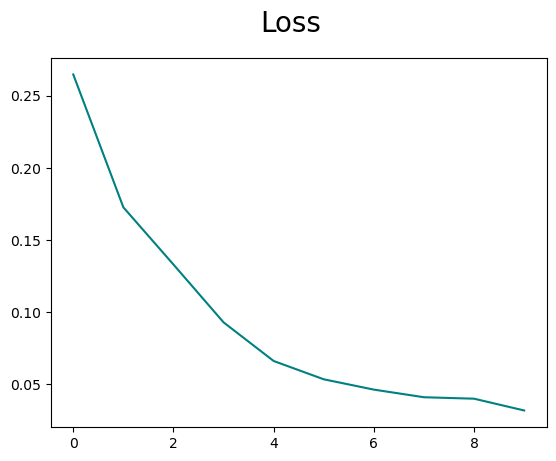

In [10]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
fig.suptitle('Loss', fontsize=20)
plt.show()

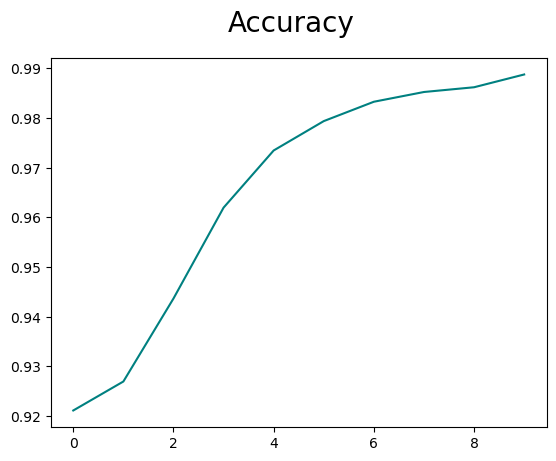

In [11]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.show()

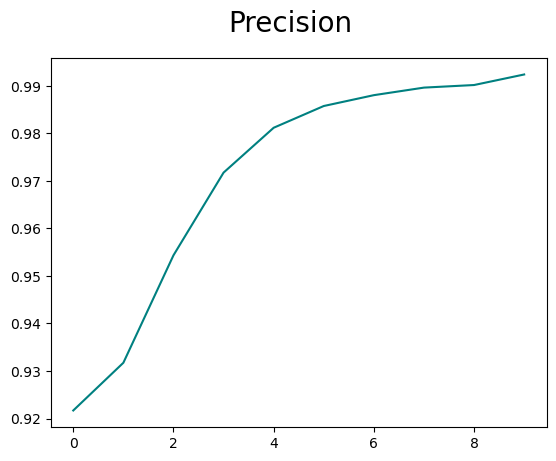

In [12]:
fig = plt.figure()
plt.plot(hist.history['precision'], color='teal', label='precision')
fig.suptitle('Precision', fontsize=20)
plt.show()

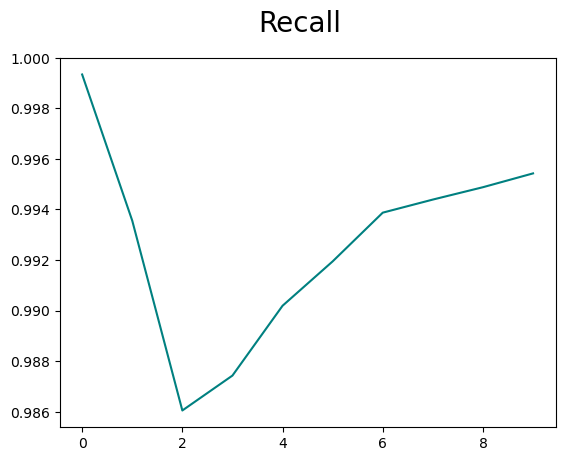

In [13]:
fig = plt.figure()
plt.plot(hist.history['recall'], color='teal', label='recall')
fig.suptitle('Recall', fontsize=20)
plt.show()

In [14]:
# Calculating F1-score for every epoch

f1_score = []

for i in range(len(hist.history['precision'])):
    x = 2 * ((hist.history['precision'][i] * hist.history['recall'][i]) / (hist.history['precision'][i] + hist.history['recall'][i]))
    f1_score.append(x)

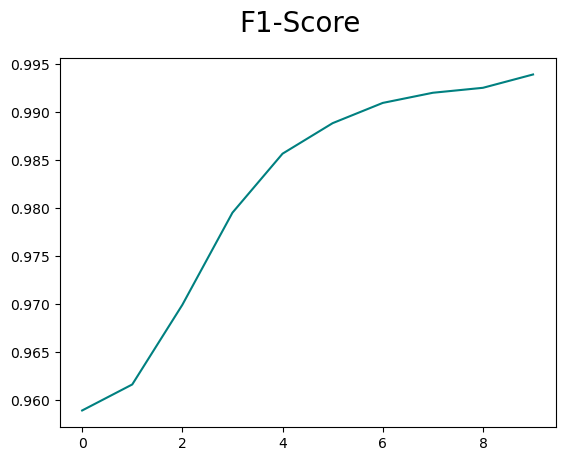

In [15]:
fig = plt.figure()
plt.plot(f1_score, color='teal', label='f1-score')
fig.suptitle('F1-Score', fontsize=20)
plt.show()

# Testing with a batch

In [16]:
# Evaluating the model using the prediction dataset
model_loss, model_accuracy, model_precision, model_recall = cnn.evaluate(test_dataset,verbose=1)

# Calculating F1-score manually
f1score = 2 * ((model_precision * model_recall) / (model_precision + model_recall))

# Printing metrics
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Precision: {model_precision}, Recall: {model_recall}, F1-score: {f1score}")

33/33 [==============================] - 3s 90ms/step - loss: 0.4148 - accuracy: 0.9220 - precision: 0.9326 - recall: 0.9866
Loss: 0.4148304760456085, Accuracy: 0.9219790697097778, Precision: 0.9325513243675232, Recall: 0.986556351184845, F1-score: 0.9587939682392389


In [18]:
# Creating confusion matrix and classification report

# Creating ground truth label list
classes = test_dataset.class_names 
y_true = []

for images, label in test_dataset:   
    for e in label:
        y_true.append(int(classes[e]))

# Creating prediction list
y_pred = cnn.predict(test_dataset)
y_pred = np.round(y_pred).tolist()

# Converting all lists gathered to arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)        

print(" ")
print("Confusion matrix:") 
print("---------------------")
print(cm)
print(" ")

# Generating classification report
clr = classification_report(y_true, y_pred, target_names=classes)

print("Classification Report:") 
print("---------------------")
print(clr)

33/33 [==============================] - 3s 92ms/step
 
Confusion matrix:
---------------------
[[  3  81]
 [ 25 942]]
 
Classification Report:
---------------------
              precision    recall  f1-score   support

           0       0.11      0.04      0.05        84
           1       0.92      0.97      0.95       967

    accuracy                           0.90      1051
   macro avg       0.51      0.50      0.50      1051
weighted avg       0.86      0.90      0.88      1051



**Result**

Accuracy of 90-92.1%, with precision of 93.2%, recall of 98.78% and F1-score of 95.9%.

Note: The comparison made with HOTARU v1.1 from this point forward is not using results from production2.ipynb, but rather v1.1_further_testing.ipynb as identical test datasets were used. This allows for a fair comparison.

When comparing v1.2 with v1.1, v1.1 proved to be slightly better than v1.2 in every regard; v1.2 performed a percent lower than v1.1. Moreover, the confusion matrixes of both version are nearly identical, with v1.2 having one more false negative than v1.1 and v1.1 having one more true positive than v1.2.

In summary, there was little change in performance between both versions, despite the numerous changes done to v1.2.

# Testing with a single picture / Showcasing SPARK script

In [19]:
# Creating preprocessing function
def prepro(img_path, cmap_type='gray'):
    # Loading in image
    img = Image.open(img_path)
    
    '''
    Section 1: Translating image into array
    '''
    # Resize the image to a consistent size (e.g., 224x224)
    img = img.resize((300, 300))

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Create original image variable for comparison - this is not in image_preprocessing.py
    img_ori = img_array
    
    # Normalize pixel values
    img_array = cv2.normalize(img_array, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

    '''
    Section 2: Creating the mask to remove unnecessary features like healthy skin and hair.
    Hair is first removed with the DullRazor algorithm, resulting in an image which is then used
    to create a mask highlighting the skinmark.
    '''
    # Converting RGB picture to greyscale for hair removal
    img_gc = color.rgb2gray(img_array)

    #DullRazor algorithm starts here
    #Black hat filter
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(img_gc, cv2.MORPH_BLACKHAT, kernel)
    
    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)

    #Masking hair
    ret, mask = cv2.threshold(bhg,0.03,255,cv2.THRESH_BINARY)
    
    # Normalise mask
    mask = cv2.normalize(mask, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    
    #Replace pixels in img_array covered in mask to create image without hair
    dst = cv2.inpaint(img_array, mask, 6, cv2.INPAINT_TELEA)
    #DullRazor algorithm ends here

    # Segmentation preparation
    # Adjusting exposure
    img_ex1 = exposure.adjust_log(dst)

    p2, p98 = np.percentile(img_ex1, (2, 98))
    img_ex2 = exposure.rescale_intensity(img_ex1, in_range=(p2, p98))

    # Converting cleaned photo into greyscale for thresholding/segmentation
    img_ex2 = color.rgb2gray(img_ex2)

    # Global thresholding with Otsu
    thresh = threshold_otsu(img_ex2)
    
    # Creating threshold image
    img_t = img_ex2 <= thresh

    # Creating mask using threshold image
    # Value 0 as black and white photo used
    mask = np.where(img_t >= 0, img_t, 0)

    '''
    Section 3: Creating the final processed photo by only including parts of img_array that is highlighted by the mask.
    '''
    # Nested for loop for each 'row' of img
    for h in range(mask.shape[0]):
      # For each 'column' of img
        for w in range(mask.shape[1]):
          # If the pixel chosen from the mask is white, add in the pixel from the original image
          # Otherwise, discard/make pixel black
            if mask[h][w] == 0:
                for i in range(3):
                    img_array[h][w][i] = 0
            else:
                continue

    # Show original and preprocessed photo side by side
    plt.subplot(1, 2, 1)
    plt.imshow(img_ori, cmap=cmap_type)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_array, cmap=cmap_type)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return img_array

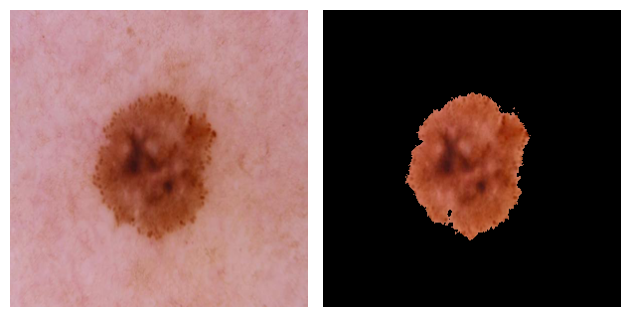

In [24]:
# Feeding model with a photo with a ground truth of having skin cancer

# Preprocessing image
img1 = prepro("img_data/test/1/ISIC_0028033.jpg")

In [26]:
# Model prediction
pred1 = cnn.predict(np.expand_dims(img1/255, 0))

if pred1 > 0.5:
    print("Skin cancer detected")
else:
    print("Skin cancer not detected")

pred1

1/1 [==============================] - 0s 27ms/step
Skin cancer detected


array([[0.62931806]], dtype=float32)

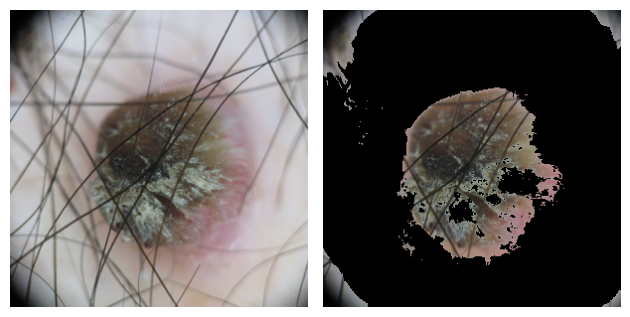

In [27]:
# Feeding model with a photo with a ground truth of NOT having skin cancer

# Preprocessing image
img2 = prepro("img_data/test/0/ISIC_0068219.jpg")

In [28]:
# Model prediction
pred2 = cnn.predict(np.expand_dims(img2/255, 0))

if pred2 > 0.5:
    print("Skin cancer detected")
else:
    print("Skin cancer not detected")

pred2

1/1 [==============================] - 0s 24ms/step
Skin cancer detected


array([[0.6309792]], dtype=float32)

**Results**

Correctly identified skin cancer image, but did not correctly identify non-skin cancer image.

## Saving the model

In [29]:
# Export our model to HDF5 file
cnn.save("models/prod_3.h5")

C:\Users\dalet\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# Exporting model as Pickle file
import pickle

pickle.dump(cnn, open('models/prod_3.pkl', 'wb'))

**Moving forward**
- 